# BIZ 프로젝트 : 부실기업 예측 모형에 관한 연구

## Step3 : 모델링

할거 : 21,22(2개년도)년도 딥러닝 모델 구축

### 0. 라이브러리 및 데이터 불러오기

라이브러리 불러오기

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam


폰트 지정

In [2]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

데이터 불러오기(21 to 22 2개년도 데이터)

In [3]:
RANDOM_STATE = 110

data_21to22 = pd.read_csv("../../project/data/data_21to22.csv", encoding='utf-8-sig', low_memory=False)
print(data_21to22.shape)

(27603, 90)


### 모델링

In [4]:
# 종속 변수는 '2023/부실기업'으로 가정
y = data_21to22['2023/부실기업']
X = data_21to22.drop(columns=['2023/부실기업', '업체코드', '종목명'])

# 데이터 분할 (70:30 비율)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 설명가능한? 모델? 

딥러닝 모델로 할라다가 잘 안되서 rf로 일단 한번 해봤음

### 1. SHAP

In [5]:
# %pip install shap
# %pip install lime

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import shap
from lime.lime_tabular import LimeTabularExplainer


# 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf_model.fit(X_train_scaled, y_train)

# 모델 평가
accuracy = rf_model.score(X_test_scaled, y_test)
print(f"Random Forest Accuracy: {accuracy:.4f}")


Random Forest Accuracy: 0.9513


In [7]:
# SHAP 값 계산
explainer = shap.Explainer(rf_model)
shap_values = explainer(X_test_scaled)

In [8]:
# 설명할 단일 관측값 선택
sample_index = 12
observation = X_test_scaled[sample_index].reshape(1, -1)

Glyph 8722 (\N{MINUS SIGN}) missing from current font.


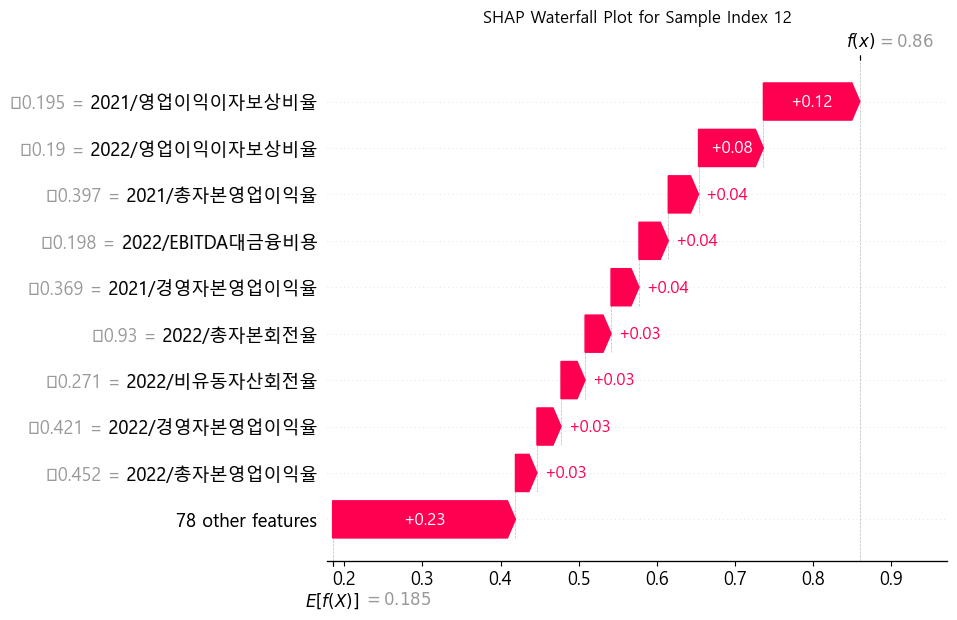

In [13]:
# 관측값에 대한 SHAP waterfall plot 생성
plt.title(f'SHAP Waterfall Plot for Sample Index {sample_index}')

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[1][0],  # 단일 샘플에 대한 SHAP 값
        feature_names=X.columns, 
        base_values=explainer.expected_value[1],  # 클래스 1의 기본값
        data=observation[0]
    ),
    max_display=10
)

plt.show()

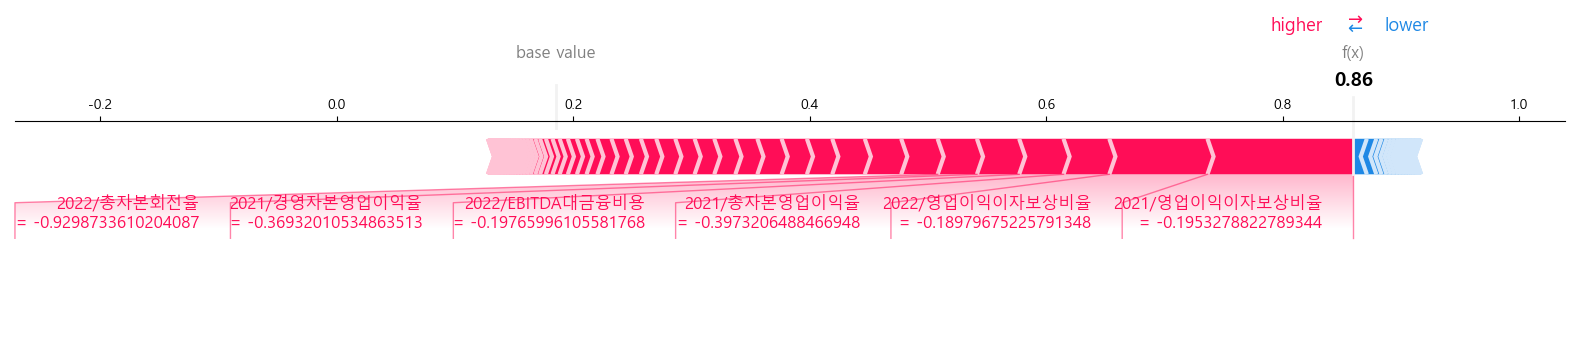

In [11]:
import shap
import matplotlib.pyplot as plt

# 관측값에 대한 SHAP 값 계산
shap_values = explainer.shap_values(observation)

# 변수명과 값을 결합하여 두 줄로 표시 (소수 넷째자리에서 반올림)
feature_names_with_values = [f"{name}\n" for name, value in zip(X.columns, observation[0])]

# 관측값에 대한 SHAP force plot 생성
shap.initjs()
force_plot = shap.force_plot(
    explainer.expected_value[1],              # 이진 분류의 경우 클래스 인덱스 선택 (예: [1])
    shap_values[1],                           # 특정 클래스와 인스턴스에 대한 SHAP 값
    observation,
    feature_names=feature_names_with_values,  # 변수명과 값을 결합하여 두 줄로 표시
    matplotlib=True                           # 정적 이미지를 위한 matplotlib 기반 플롯 사용
)

이때 f(x)는 해당 기업(x)가 부실기업일 확률에 대한 예측값 

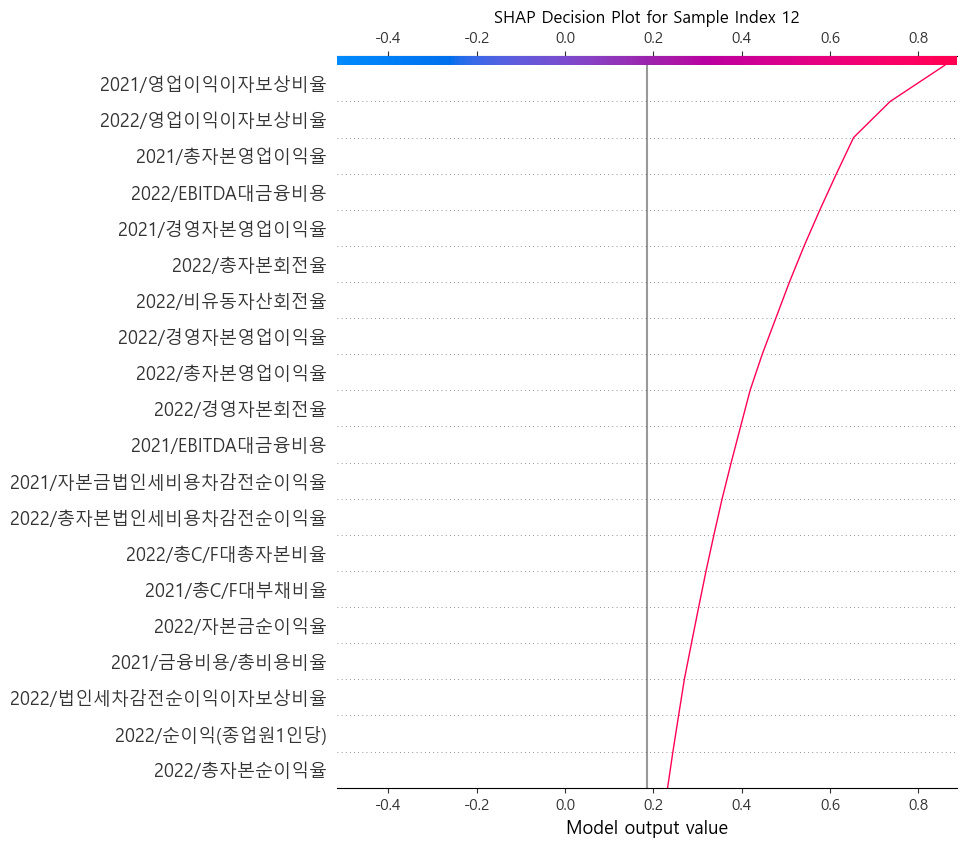

In [14]:
# SHAP decision plot 생성
plt.title(f'SHAP Decision Plot for Sample Index {sample_index}')

shap.decision_plot(
    explainer.expected_value[1],  # 클래스 1의 기본값
    shap_values[1],               # 특정 클래스에 대한 SHAP 값
    feature_names=list(X.columns) # 원래 데이터셋의 변수명을 리스트로 변환하여 전달
)

plt.show()

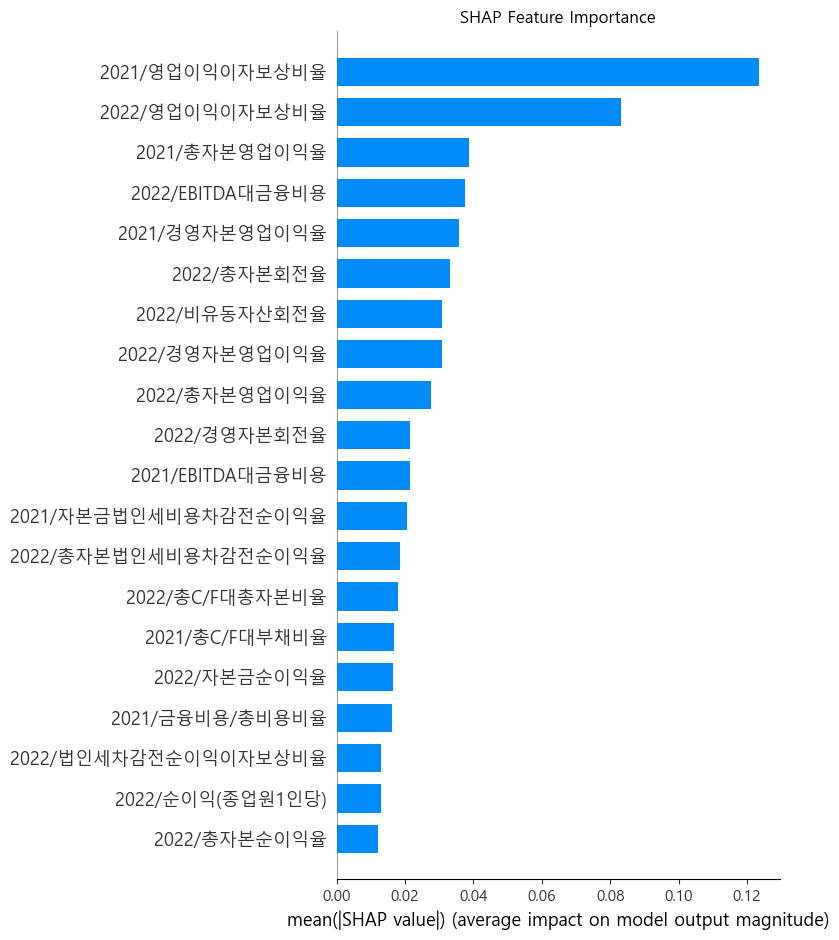

In [15]:
# SHAP feature importance plot 생성
plt.title('SHAP Feature Importance')

shap.summary_plot(
    shap_values[1],               # 특정 클래스에 대한 SHAP 값
    X_test,                       # 테스트 데이터
    feature_names=X.columns,      # 원래 데이터셋의 변수명
    plot_type='bar'               # 막대 그래프 형태로 표시
)

plt.show()

### 2. LIME

<Figure size 6000x4000 with 0 Axes>

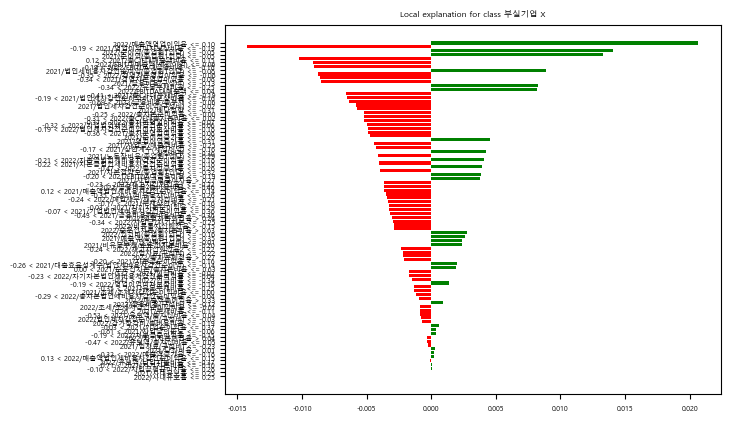

In [20]:
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# LIME 설명자 생성
lime_explainer = LimeTabularExplainer(X_train_scaled, feature_names=X.columns, class_names=['부실기업 O', '부실기업 X'], discretize_continuous=True)

# 특정 샘플 선택 (예: 첫 번째 테스트 샘플)
sample_idx = 0
sample = X_test_scaled[sample_idx]

# LIME 설명 생성
num_features = X_test_scaled.shape[1]  # 모든 변수를 사용
lime_exp = lime_explainer.explain_instance(sample, rf_model.predict_proba, num_features=num_features)

# LIME 결과 시각화
plt.figure(figsize=(60, 40))  # 원하는 크기로 조절
plt.rcParams.update({'font.size': 5})  # 폰트 크기 조절
lime_exp.as_pyplot_figure()
plt.show()

<Figure size 3000x2000 with 0 Axes>

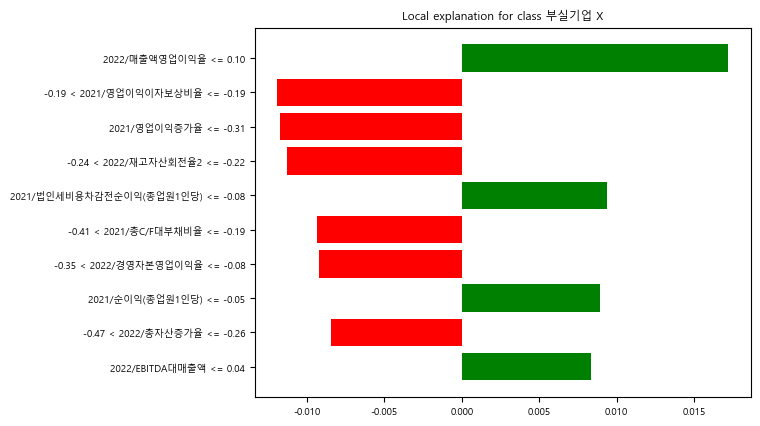

In [21]:
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# LIME 설명자 생성
lime_explainer = LimeTabularExplainer(X_train_scaled, feature_names=X.columns, class_names=['부실기업 O', '부실기업 X'], discretize_continuous=True)

# 특정 샘플 선택 (예: 첫 번째 테스트 샘플)
sample_idx = 0
sample = X_test_scaled[sample_idx]

# LIME 설명 생성
lime_exp = lime_explainer.explain_instance(sample, rf_model.predict_proba, num_features=10)

# LIME 결과 시각화
plt.figure(figsize=(30, 20))  # 원하는 크기로 조절
plt.rcParams.update({'font.size': 7})  # 폰트 크기 조절
lime_exp.as_pyplot_figure()
plt.show()

<Figure size 1000x800 with 0 Axes>

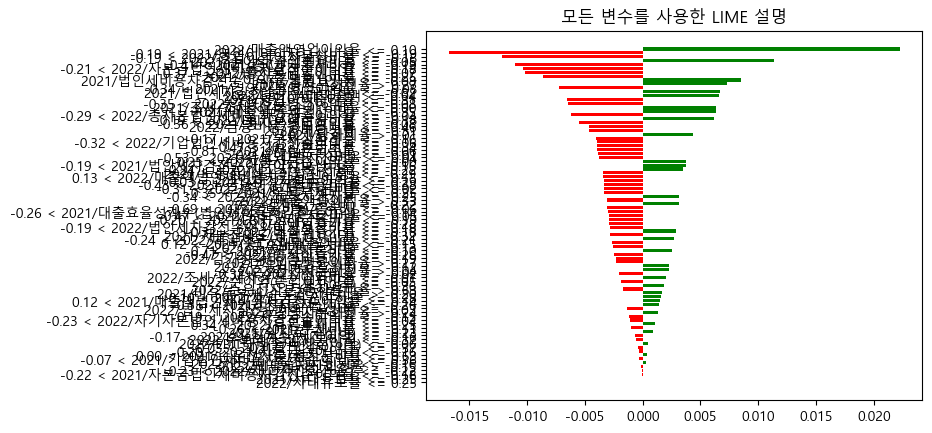

<Figure size 1000x800 with 0 Axes>

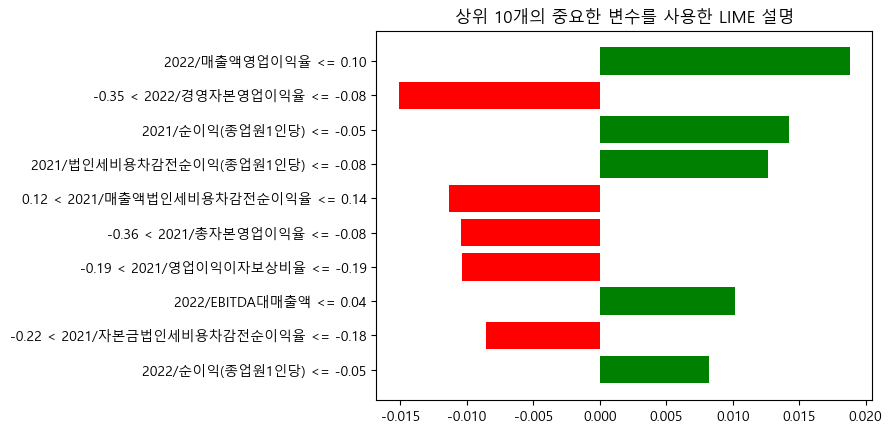

Feature: 2022/매출액영업이익율 <= 0.10, Importance: 0.018808764608705276
Feature: -0.35 < 2022/경영자본영업이익율 <= -0.08, Importance: -0.015104993111206484
Feature: 2021/순이익(종업원1인당) <= -0.05, Importance: 0.014234881827325114
Feature: 2021/법인세비용차감전순이익(종업원1인당) <= -0.08, Importance: 0.012687680554247526
Feature: 0.12 < 2021/매출액법인세비용차감전순이익율 <= 0.14, Importance: -0.011333284288850822
Feature: -0.36 < 2021/총자본영업이익율 <= -0.08, Importance: -0.010443896163483572
Feature: -0.19 < 2021/영업이익이자보상비율 <= -0.19, Importance: -0.010360273937836378
Feature: 2022/EBITDA대매출액 <= 0.04, Importance: 0.010170504485264787
Feature: -0.22 < 2021/자본금법인세비용차감전순이익율 <= -0.18, Importance: -0.008548689084897853
Feature: 2022/순이익(종업원1인당) <= -0.05, Importance: 0.008250500528152715
이 기업이 부실기업으로 예측된 주요 이유는 다음과 같습니다:
- 2022/매출액영업이익율 <= 0.10: 0.0188
- -0.35 < 2022/경영자본영업이익율 <= -0.08: -0.0151
- 2021/순이익(종업원1인당) <= -0.05: 0.0142
- 2021/법인세비용차감전순이익(종업원1인당) <= -0.08: 0.0127
- 0.12 < 2021/매출액법인세비용차감전순이익율 <= 0.14: -0.0113
- -0.36 < 2021/총자본영업이익율 <= 

In [22]:
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer

# LIME 설명자 생성
lime_explainer = LimeTabularExplainer(X_train_scaled, feature_names=X.columns, class_names=['부실기업 O', '부실기업 X'], discretize_continuous=True)

# 특정 샘플 선택 (예: 첫 번째 테스트 샘플)
sample_idx = 0
sample = X_test_scaled[sample_idx]

# 모든 변수를 사용한 LIME 설명 생성
num_features_all = X_test_scaled.shape[1]  # 모든 변수를 사용
lime_exp_all = lime_explainer.explain_instance(sample, rf_model.predict_proba, num_features=num_features_all)

# 상위 10개의 중요한 변수를 사용한 LIME 설명 생성
num_features_top10 = 10  # 상위 10개의 변수를 사용
lime_exp_top10 = lime_explainer.explain_instance(sample, rf_model.predict_proba, num_features=num_features_top10)

# 모든 변수를 사용한 LIME 결과 시각화
plt.figure(figsize=(10, 8))  # 원하는 크기로 조절
plt.rcParams.update({'font.size': 10})  # 폰트 크기 조절
lime_exp_all.as_pyplot_figure()
plt.title("모든 변수를 사용한 LIME 설명")
plt.show()

# 상위 10개의 중요한 변수를 사용한 LIME 결과 시각화
plt.figure(figsize=(10, 8))  # 원하는 크기로 조절
plt.rcParams.update({'font.size': 10})  # 폰트 크기 조절
lime_exp_top10.as_pyplot_figure()
plt.title("상위 10개의 중요한 변수를 사용한 LIME 설명")
plt.show()

# LIME 설명 결과 출력
lime_exp_list = lime_exp_top10.as_list()
for feature, importance in lime_exp_list:
    print(f"Feature: {feature}, Importance: {importance}")

# 부실기업 여부에 영향을 미친 상위 10개 변수에 대한 설명 생성
explanation_text = "이 기업이 부실기업으로 예측된 주요 이유는 다음과 같습니다:\n"
for feature, importance in lime_exp_list[:10]:
    explanation_text += f"- {feature}: {importance:.4f}\n"

explanation_text += "\n이러한 수치들에 대한 대처를 진행하지 않는다면, 1년 뒤에 부실기업으로 이어질 수 있습니다."

print(explanation_text)

.